In [580]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import softmax
import seaborn as sns
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# ignorování warningů
warnings.simplefilter(action='ignore', category=FutureWarning)


## Bayesovské odhady
### Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení

In [581]:
# načtení dat pro první úlohu
first_task_data = pd.read_excel('Projekt-2_Data.xlsx', sheet_name='Úloha 1')
first_task_data


,uloha_1 a),uloha_1 b)_prior,skupina,uloha_1 b)_pozorování
0,2.0,3.634785,0,3.626656
1,2.0,2.868113,0,3.008269
2,1.0,2.149160,0,2.989829
3,3.0,4.263065,0,2.371630
4,0.0,2.594745,0,4.009366
...,...,...,...,...
99995,NaN,1.725637,9999,NaN
99996,NaN,4.048414,9999,NaN
99997,NaN,3.000662,9999,NaN
99998,NaN,3.058451,9999,NaN


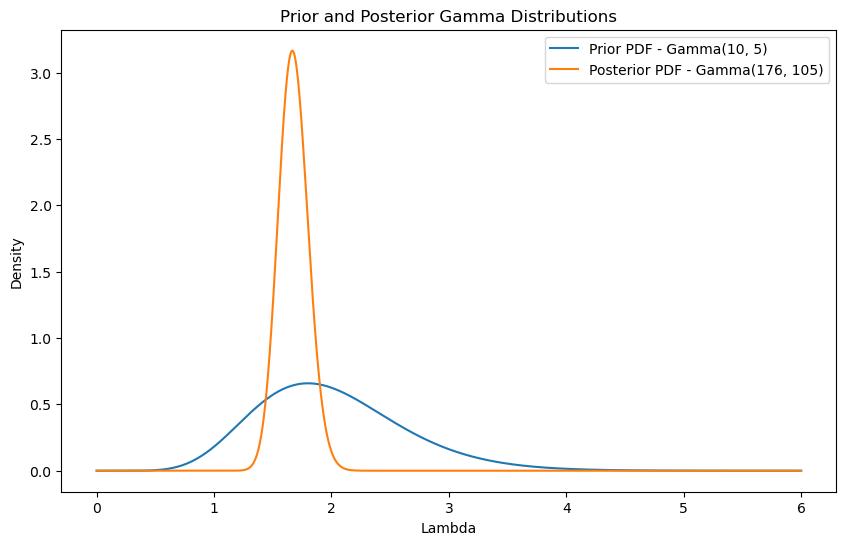

In [582]:
subtask_a_data = first_task_data["uloha_1 a)"].dropna()

alpha_prior = 10.0
beta_prior = 5.0

alpha_posterior = alpha_prior + subtask_a_data.sum()
beta_posterior = beta_prior + subtask_a_data.size

lambda_values = np.linspace(0, 6, 10000)

prior_pdf = stats.gamma.pdf(lambda_values, a=alpha_prior, scale= 1 / beta_prior)
posterior_pdf = stats.gamma.pdf(lambda_values, a=alpha_posterior, scale= 1 / beta_posterior)

plt.figure(figsize=(10, 6))
plt.plot(lambda_values, prior_pdf, label='Prior PDF - Gamma(10, 5)')
plt.plot(lambda_values, posterior_pdf, label='Posterior PDF - Gamma(176, 105)')
plt.title('Prior and Posterior Gamma Distributions')
plt.xlabel('Lambda')
plt.ylabel('Density')
plt.legend()
plt.show()


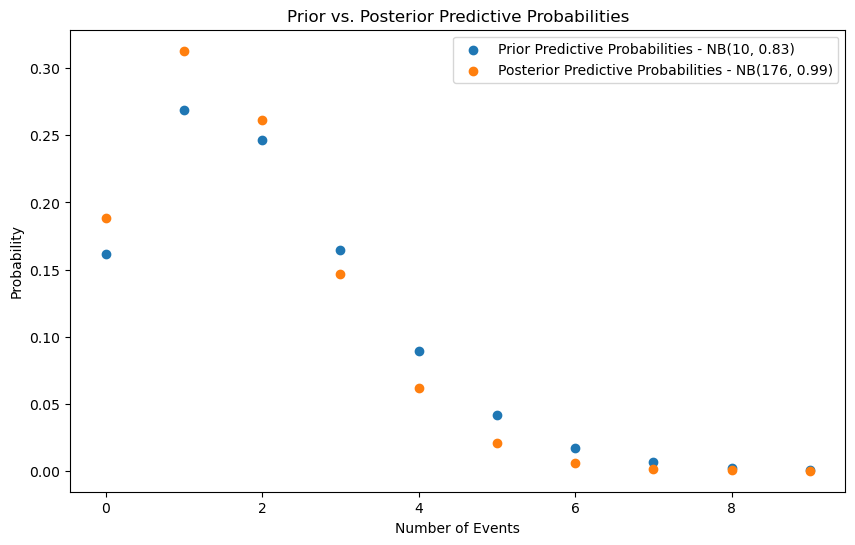

In [583]:
# parametry pro negativní binomické rozdělení - NB(r, p)
r_prior = alpha_prior
r_posterior = alpha_posterior
p_prior = beta_prior / (beta_prior + 1)
p_posterior = beta_posterior / (beta_posterior + 1)

padding = 5
max_connections = subtask_a_data.max()

x_values = np.arange(0, max_connections + padding)

prior_predictive_probs = stats.nbinom.pmf(x_values, r_prior, p_prior)
posterior_predictive_probs = stats.nbinom.pmf(x_values, r_posterior, p_posterior)

plt.figure(figsize=(10, 6))
plt.scatter(x_values, prior_predictive_probs, label='Prior Predictive Probabilities - NB(10, 0.83)')
plt.scatter(x_values, posterior_predictive_probs, label='Posterior Predictive Probabilities - NB(176, 0.99)')
plt.title('Prior vs. Posterior Predictive Probabilities')
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.legend()
plt.show()


In [584]:
lower_percentile = 0.025  
upper_percentile = 0.975

lambda_prior_lower = stats.gamma.ppf(lower_percentile, a=alpha_prior, scale=1/beta_prior)
lambda_prior_upper = stats.gamma.ppf(upper_percentile, a=alpha_prior, scale=1/beta_prior)

lambda_posterior_lower = stats.gamma.ppf(lower_percentile, a=alpha_posterior, scale=1/beta_posterior)
lambda_posterior_upper = stats.gamma.ppf(upper_percentile, a=alpha_posterior, scale=1/beta_posterior)

print("95% interval spolehlivosti pro parametr 𝜆 z aprio. rozdělení: <{}, {}>".format(lambda_prior_lower, lambda_prior_upper))
print("95% interval spolehlivosti pro parametr 𝜆 z apost. rozdělení: <{}, {}>".format(lambda_posterior_lower, lambda_posterior_upper))


95% interval spolehlivosti pro parametr 𝜆 z aprio. rozdělení: <0.9590777392264868, 3.416960690283833>
95% interval spolehlivosti pro parametr 𝜆 z apost. rozdělení: <1.4376938284869922, 1.9327207471868797>


Na základě spočítaných 95% intervalů spolehlivosti můžeme říci, že díky poskytnutým pozorováním jsme schopni výrazně zpřesnit odhad parametru $\lambda$, tedy výsledný interval aposteriorního rozdělení je užší než interval rozdělení apriorního.

In [585]:
lambda_posterior_mean = alpha_posterior / beta_posterior
lambda_posterior_median = stats.gamma.median(a=alpha_posterior, scale=1/beta_posterior)
lambda_posterior_mode = lambda_values[posterior_pdf.argmax()]

print("Bodový odhad parametru 𝜆 na základě střední hodnoty:", lambda_posterior_mean)
print("Bodový odhad parametru 𝜆 na základě mediánu:", lambda_posterior_median)
print("Bodový odhad parametru 𝜆 na základě modusu:", lambda_posterior_mode)


Bodový odhad parametru 𝜆 na základě střední hodnoty: 1.6761904761904762
Bodový odhad parametru 𝜆 na základě mediánu: 1.6730169441241727
Bodový odhad parametru 𝜆 na základě modusu: 1.666966696669667


Bodový odhad byl spočítaný jak střední hodnotou, mediánem, tak i modusem. Výsledky jednotlivých odhadů jsou téměř identické. To je způsobeno tím, že aposteriorní rozdělení parametru $\lambda$ se blíží normálnímu rozdělení.  

In [586]:
events_prior_mean = r_prior * (1.0 - p_prior) / p_prior
events_posterior_mean = r_posterior * (1.0 - p_posterior) / p_posterior

print("(Apriori) Bodový odhad počtu pozorování na základě střední hodnoty:", events_prior_mean)
print("(Aposteriori) Bodový odhad počtu pozorování na základě střední hodnoty:", events_posterior_mean)

(Apriori) Bodový odhad počtu pozorování na základě střední hodnoty: 1.9999999999999996
(Aposteriori) Bodový odhad počtu pozorování na základě střední hodnoty: 1.6761904761904758


Jak pro apriorní, tak i asposteriorní prediktivní hustotu byl bodový odhad počtu pozorování spočítán na základě střední hodnoty. Střední hodnota apriorní prediktivní hustoty reprezentuje expertní odhad, zatímco aposteriorní
prediktviní hustota je upravena na základě poskytnutých pozorování. Je vidět, že "realný" počet pozorování, tedy počet připojení do internetové sítě za 1 ms bude spíše menší, než bylo původně stanoveno expertním odhadem.

### Aproximace diskrétním rozdělením

$$
P(b|d_1, d_2, \cdots, d_n) = \frac{\prod_{i=1}^{n} P(d_i|b) \cdot P(b)}{\sum_{b \in B} \left(\prod_{i=1}^{n} P(d_i|b) \cdot P(b)\right)}
$$

$d_1, d_2, \cdots, d_n$ jsou pozorování \
$b$ je hledaný parametr odseknutého normalního rozdělení \
${\prod_{i=1}^{n} P(d_i|b)}$ je věrohodností funkce pro daný parametr $b$ \
$P(b)$ je apriorní pravděpodobnost parametru b \
${\sum_{b \in B} \left(\prod_{i=1}^{n} P(d_i|b) \cdot P(b)\right)}$ je suma všech věrohodnostních funkcí spolu s jejich apriorníma pravděpodobnostma (normalizační člen) \
$P(b|d_1, d_2, \cdots, d_n)$ je potom aposteriorní "hustota"




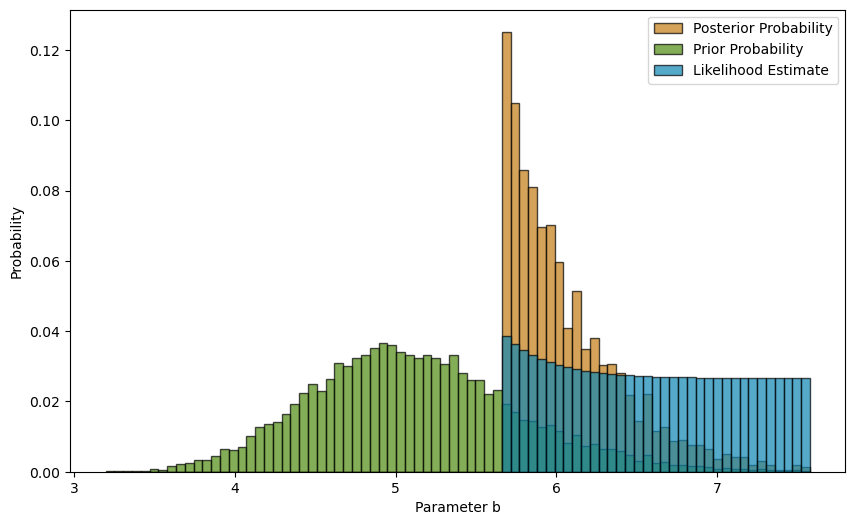

In [587]:
# z každé skupiny vybereme maximální hodnotu
subtask_b_prior = first_task_data[["uloha_1 b)_prior", "skupina"]].groupby("skupina").max()
subtask_b_observations = first_task_data["uloha_1 b)_pozorování"].dropna()

bin_values_num = 80

# soubor maximálních hodnot z jednotlivých skupin setřídíme do 80 binů o stejné šířce
prior_freq, bins = np.histogram(subtask_b_prior, bins=bin_values_num)
prior_prob = prior_freq / prior_freq.sum()

# vypočítáme středy binů
bin_centers = 0.5 * (bins[1:] + bins[:-1])

mu = 3
sigma = 1
a_standard = (1 - mu) / sigma

log_likelihoods = []

# pro středy všech binů (reprezentující parametr b) vypočítáme logaritmus likelihoodu
# jinými slovy vypočítáme, jak dobře odpovídají poskytnutá pozorování odseknutému normálnímu
# rozdělení pro různé hodnoty parametru b
for b in bin_centers:
  b_standard = (b - mu) / sigma
  log_pdf_values = stats.truncnorm(a=a_standard, b=b_standard, loc=mu, scale=sigma).logpdf(subtask_b_observations)
  log_likelihoods.append(np.sum(log_pdf_values))


# pomocí softmaxu převedeme logaritmy likelihoodů na pravděpodobnosti
likelihood_prob = softmax(log_likelihoods)


# vypočítáme aposteriorní pravděpodobnosti pomocí Bayesova vzorce
posterior_freq = prior_prob * likelihood_prob
posterior_prob = posterior_freq / posterior_freq.sum()

plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins, weights=posterior_prob, label='Posterior Probability', alpha=0.7, color='#C47B12', edgecolor='black')
plt.hist(bins[:-1], bins, weights=prior_prob, label='Prior Probability', alpha=0.7, color='#508A11', edgecolor='black')
plt.hist(bins[:-1], bins, weights=likelihood_prob, label='Likelihood Estimate', alpha=0.7, color='#0F86B3', edgecolor='black')
plt.xlabel('Parameter b')
plt.ylabel('Probability')
plt.legend()
plt.show()


95% interval spolehlivosti můžeme nasledně spočítat akumulací pravděpodobností jednotlivých binů, tedy ščítáme aspoteriorní pravděpodobnostní funkci zleva a hledáme takovou hodnotu na ose x, jejíž hodnota bude odpovídat 2.5 percentilu a tedy spodní hranici intervalu. Horní hranici získáme akumulací pravděpodobností až do hodnoty 0.975, tedy 97.5 percentil.

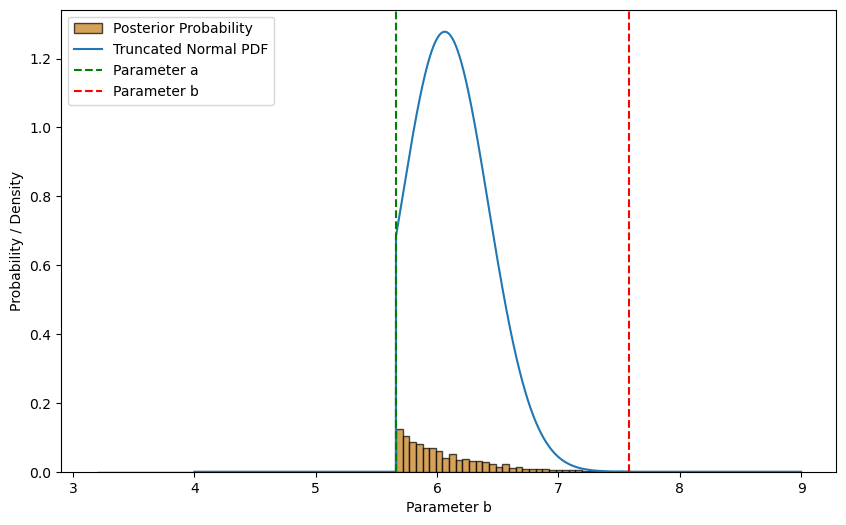

(Histogram) 95% interval spolehlivosti pro parametr b z apost. rozdělení: <5.688232034015019, 7.003430634180411>
(Hustota pravděpodobnosti) 95% interval spolehlivosti pro parametr b z apost. rozdělení: <5.695559618614321, 6.788843572739788>


In [588]:
# výpočet 95% intervalu spolehlivosti na základě histogramu
cumulative_probs = np.cumsum(posterior_prob)

# najdeme bin, který +- odpovídá 2.5 percentilu
lower_idx = np.argmax(cumulative_probs >= 0.025)
b_posteriro_lower_hist = bin_centers[lower_idx]

# najdeme bin, který +- odpovídá 97.5 percentilu
upper_idx = np.argmax(cumulative_probs >= 0.975)
b_posteriro_upper_hist = bin_centers[upper_idx]

mean = np.sum(bin_centers * posterior_prob)
std_dev = np.sqrt(np.sum(posterior_prob * (bin_centers - mean)**2))

# výpočet 95% intervalu spolehlivosti na základě hustoty pravděpodobnosti
a = posterior_prob.nonzero()[0][0]
a_standard = (bins[a] - mean) / std_dev
b_standard = (bins[-1] - mean) / std_dev

x_range = np.linspace(4, 9, 5000)

plt.figure(figsize=(10, 6))
plt.hist(bins[:-1], bins, weights=posterior_prob, label='Posterior Probability', alpha=0.7, color='#C47B12', edgecolor='black')
plt.plot(x_range, stats.truncnorm.pdf(x_range, a=a_standard, b=b_standard, loc=mean, scale=std_dev), label='Truncated Normal PDF',)
plt.axvline(x=bins[a], color='green', linestyle='--', label='Parameter a')
plt.axvline(x=bins[-1], color='red', linestyle='--', label='Parameter b')
plt.xlabel('Parameter b')
plt.ylabel('Probability / Density')
plt.legend()
plt.show()

b_posteriro_lower_pdf = stats.truncnorm.ppf(lower_percentile, a=a_standard, b=b_standard, loc=mean, scale=std_dev)
b_posteriro_upper_pdf = stats.truncnorm.ppf(upper_percentile, a=a_standard, b=b_standard, loc=mean, scale=std_dev)

print("(Histogram) 95% interval spolehlivosti pro parametr b z apost. rozdělení: <{}, {}>".format(b_posteriro_lower_hist, b_posteriro_upper_hist))
print("(Hustota pravděpodobnosti) 95% interval spolehlivosti pro parametr b z apost. rozdělení: <{}, {}>".format(b_posteriro_lower_pdf, b_posteriro_upper_pdf))


Jako bodové odhady byly vybrány střední hodnota a modus. Na první pohled je z grafu vidět, že se hodnoty budou lišit, jelikož modus bude taková hodnota na ose x, kde odseknuté normální rozdělení nabývá největší pravděpobnosti, zatímco střední hodnota bude vyvážena i většíma hodnotama parametru $b$, ačkoli jejich pravděpodobnost není tak velká.

In [589]:
mode = bin_centers[posterior_prob.argmax()]

print("Bodový odhad parametru b na základě střední hodnoty:", mean)
print("Bodový odhad parametru b na základě modusu:", mode)


Bodový odhad parametru b na základě střední hodnoty: 6.063248915799402
Bodový odhad parametru b na základě modusu: 5.688232034015019


# Lineární regrese

Před tím, než se pokusíme vytvořit samotný regresní model, musíme si připravit data. Jelikož je regresní model schopný pracovat pouze s numerickýma hodnotama, budeme muset převést proměnnou `OSType` na více jednotlivých proměnných, které budou značit, o jaký operační systém se jedná. V případě 4 operačních systému si vystačíme pouze se 3 proměnnýma. Dále je dobré zkontrolovat, zdali se v datasetu nenachází proměnné, které jsou na sobě lineárně zavislé. V našem případě to jsou proměnné `IntercatingPct` a `ScrollingPct`, proto jednu z nich z našeho datasetu vyřadíme.

In [590]:
# načtení dat pro druhou úlohu
second_task_data = pd.read_excel('Projekt-2_Data.xlsx', sheet_name='Úloha 2')

# vytvoříme dummy proměnné pro kategorickou proměnnou OSType
# IS_MacOS == 0 ^ IS_Windows == 0 ^ IS_iOS == 0 => IS_Android == 1
dummy_variables = pd.get_dummies(second_task_data['OSType'], drop_first=True, prefix="IS").astype(float)  

# z data framu odstraníme původní kategorickou proměnnou a přidáme dummy proměnné
second_task_data = second_task_data.drop('OSType', axis=1).join(dummy_variables)
initial_data = second_task_data.copy()
second_task_data.head()


,ActiveUsers,InteractingPct,ScrollingPct,Ping [ms],IS_MacOS,IS_Windows,IS_iOS
0,4113,0.8283,0.1717,47,0.0,0.0,1.0
1,7549,0.3461,0.6539,46,0.0,0.0,1.0
2,8855,0.2178,0.7822,55,0.0,1.0,0.0
3,8870,0.0794,0.9206,56,0.0,0.0,0.0
4,9559,0.7282,0.2718,76,1.0,0.0,0.0


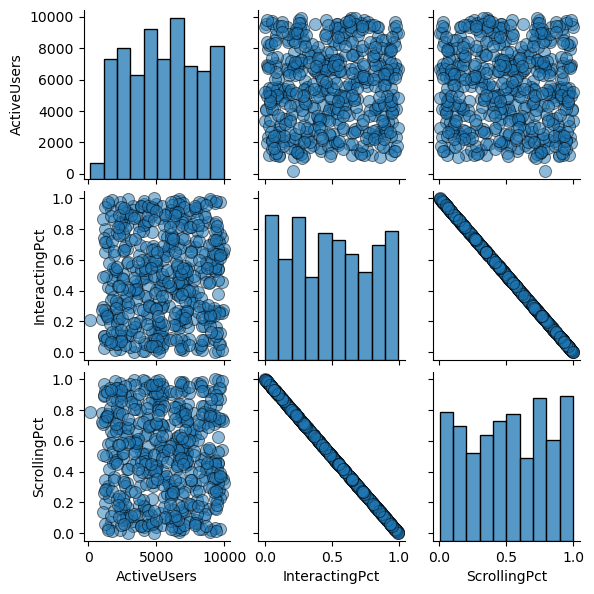

In [591]:
predictors = second_task_data[['ActiveUsers', 'InteractingPct', 'ScrollingPct']]

# vztahy jednotlivých prediktorů
sns.pairplot(predictors, plot_kws={'alpha': 0.5, 's': 75, 'edgecolor': 'k'}, height=2.)


In [592]:
# proměnné InteractingPct a ScrollingPct jsou linárně závislé, jednu z nich tedy odstraníme
second_task_data.drop('InteractingPct', axis=1, inplace=True)
second_task_data.head()


,ActiveUsers,ScrollingPct,Ping [ms],IS_MacOS,IS_Windows,IS_iOS
0,4113,0.1717,47,0.0,0.0,1.0
1,7549,0.6539,46,0.0,0.0,1.0
2,8855,0.7822,55,0.0,1.0,0.0
3,8870,0.9206,56,0.0,0.0,0.0
4,9559,0.2718,76,1.0,0.0,0.0


### Výchozí plný kvadratický model
$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1^2 + \beta_4 X_2^2 + \beta_5 X_1X_2 + \beta_6 C_1 + \beta_7 C_2 + \beta_8 C_3 + \beta_9 X_1C_1 + \beta_{10} X_1C_2 + \beta_{11} X_1C_3 + \beta_{12} X_2C_1 + \beta_{13} X_2C_2 + \beta_{14} X_2C_3 + \epsilon$

$Y$ je závislá proměnná `Ping [ms]`. \
$X_1, X_2$ jsou nezávislé spojité proměnné `ActiveUsers` a `ScrollingPct`. \
$C_1, C_2, C_3$ jsou kategorické proměnné `IS_MacOS`, `IS_Windows` a `IS_iOS`. \
$\beta_0, \beta_1, \beta_2, \dotsc, \beta_{14}$ jsou hledané koeficienty. \
$\epsilon$ reprezntuje chybu způsobenou šumem ve vstupních datech.

Kdybychom pro tento model spočítali hodnoty VIF, zjistili bychom, že se v našem modelu vyskyjute velká míra multikolinearity a proto je vhodné data normalizovat, například do roszahu $\langle -1,1 \rangle$. To udělám pomocí následujícího vzorečku:
$$x_{\text{normalized}} = 2 \left( \frac{x - x_{\text{min}}}{x_{\text{max}} - x_{\text{min}}} \right) - 1$$

Samozřejmě je nutné si hodnoty $x_{\text{min}}$, $x_{\text{max}}$ zapamatovat, abychom jimiž mohli normalizovat i nově příchozí data, pro která budeme chtít zjistit predikci.

In [593]:
# normalizace prediktorů do intervalu <-1, 1>
min_values = second_task_data.drop(['Ping [ms]'], axis=1).min(axis=0)
max_values = second_task_data.drop(['Ping [ms]'], axis=1).max(axis=0)
predict_cols =  second_task_data.columns.drop('Ping [ms]')
second_task_data[predict_cols] = -1 + 2 * (second_task_data[predict_cols] - min_values) / (max_values - min_values) 

# přidání kvadratických a smíšených členů
def add_quadratic_and_interaction_terms(frame):
  frame['ActiveUsers_squared'] = frame['ActiveUsers'] ** 2
  frame['ScrollingPct_squared'] = frame['ScrollingPct'] ** 2
  frame['ActiveUsers_ScrollingPct'] = frame['ActiveUsers'] * frame['ScrollingPct']
  frame['ActiveUsers_IS_MacOS'] = frame['ActiveUsers'] * frame['IS_MacOS']
  frame['ActiveUsers_IS_Windows'] = frame['ActiveUsers'] * frame['IS_Windows']
  frame['ActiveUsers_IS_iOS'] = frame['ActiveUsers'] * frame['IS_iOS']
  frame['ScrollingPct_IS_MacOS'] = frame['ScrollingPct'] * frame['IS_MacOS']
  frame['ScrollingPct_IS_Windows'] = frame['ScrollingPct'] * frame['IS_Windows']
  frame['ScrollingPct_IS_iOS'] = frame['ScrollingPct'] * frame['IS_iOS']

add_quadratic_and_interaction_terms(second_task_data)

init_predictors = ['ActiveUsers', 'ActiveUsers_squared', 'ScrollingPct', 'ScrollingPct_squared', 'ActiveUsers_ScrollingPct', 
              'IS_MacOS', 'IS_Windows', 'IS_iOS', 'ActiveUsers_IS_MacOS', 'ActiveUsers_IS_Windows', 'ActiveUsers_IS_iOS', 
              'ScrollingPct_IS_MacOS', 'ScrollingPct_IS_Windows', 'ScrollingPct_IS_iOS']

X = sm.add_constant(second_task_data[init_predictors])
y = second_task_data['Ping [ms]']

# vytvoření výchozího modelu
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        21:48:55   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

V tabulce výše se můžeme podívat na hodnoty hledaných koeficientů pro náš výsledný model, a taky na statistiky popisující jednotlivé vlastnosti modelu. Nás ale teď bude nejvíce zajímat sloupeček $P>|t|$, který udává p-hodnoty koeficientů při testu na nulu. Tedy nulová hypotéze testu je, že koeficient $\beta_i = 0$ a je tedy zbytečné ho v modelu mít. Jestliže je p-hodnota menší jak hladina významnosti $\alpha=0.05$, pak nulovou hypotézu zamítáme. V opačném případě můžeme zkusit koeficient spolu s prediktorem (popřípadě kombinací prediktorů)  z modelu odstranit.

In [594]:
continue_removal = True
alpha = 0.05

# iterativní odstraňování prediktorů s nejvyšší p-hodnotou
while continue_removal:
    p_values = model.pvalues
    highest_p_value_idx = p_values.idxmax()

    if p_values[highest_p_value_idx] > alpha:
        X.drop(columns=[highest_p_value_idx], inplace=True)
        model = sm.OLS(y, X).fit()
        print(model.summary())
    else:
        continue_removal = False


                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     202.8
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          3.58e-187
Time:                        21:48:55   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3225.
Df Residuals:                     488   BIC:                             3284.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Z výpisu lze vidět, že po odstranění 4 koeficientů se hodnota $R-squared$ (koeficient determinace), udavající míru kvality modelu, téměř nezměnila. Tyto koeficienty je tedy opravdu zbytečné v modelu zachovat.

                               VIF
const                     5.494647
ActiveUsers               4.124834
ActiveUsers_squared       1.143915
ScrollingPct              1.031438
ActiveUsers_ScrollingPct  1.036824
IS_MacOS                  1.728634
IS_Windows                1.713664
IS_iOS                    1.650624
ActiveUsers_IS_MacOS      2.232872
ActiveUsers_IS_Windows    2.165669
ActiveUsers_IS_iOS        2.286647


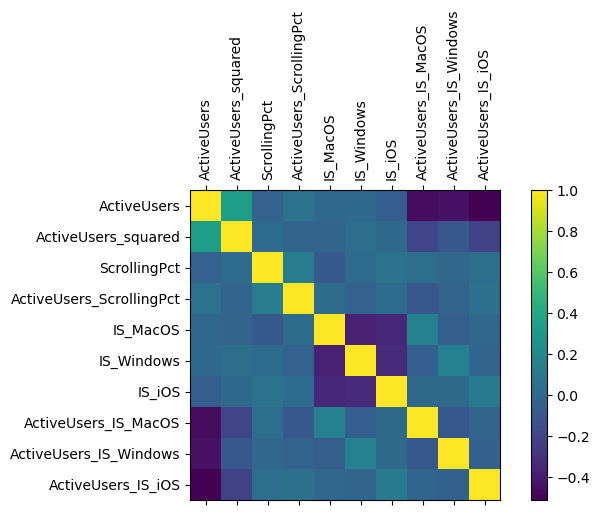

In [595]:
# VIF
vif_df = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
               index=X.columns).to_frame()
vif_df.columns = ['VIF']
print(vif_df)

# korelační matice
X_no_const = X.copy().drop(columns=['const'])
plt.figure(figsize=(8, 4))
plt.matshow(X_no_const.corr(),fignum=1)
plt.xticks(range(len(X_no_const.columns)), X_no_const.columns, rotation=90)
plt.yticks(range(len(X_no_const.columns)), X_no_const.columns)
plt.colorbar()
plt.show()


Normalita reziduií je další předpoklad, který by měl být u regresního modelu splněn. Výsledky testů Omnibus a Jarque-Bera nám ale říkají, že v případě našeho modelu tomu tak není. U obou testů vyšla p-hodnota rovna nule, což je silné zamítnutí nulové hypotézy, tedy normality. To může být způsobeno například výskytem odlehlých a vlivných bodů, které jsou schopny výsledný model výrazně ovlivnit. Proto se takové body pokusíme identifikovat a případně i odstranit.

Pozorování s velkou Cook's distance - indexy: []
Pozorování s velkou pákou - indexy: [476]
Pozorování s velkými rezidui - indexy: [ 82 255 476]


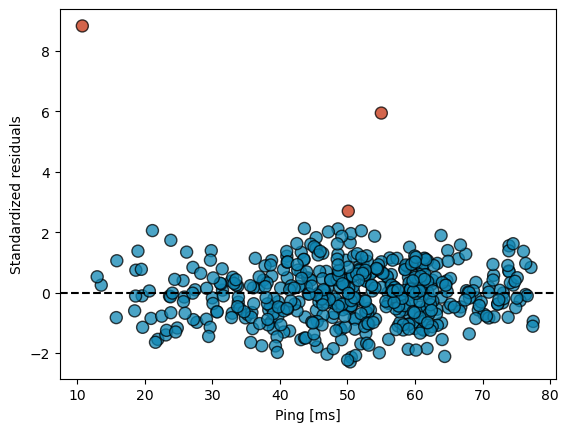

In [596]:
influence = model.get_influence()

# podezřelé hodnoty - p_value < 0.05
_, p_value = influence.cooks_distance
cooks_distance_outliers_idxs = np.where(p_value < 0.05)[0]
print("Pozorování s velkou Cook's distance - indexy:", cooks_distance_outliers_idxs)

# podezřelé hodnoty - leverage >  3 x počet parametrů / počet pozorování
leverage = influence.hat_matrix_diag
leverage_outliers_idx = np.where(leverage > 3 * model.params.size / X.shape[0])[0]
print("Pozorování s velkou pákou - indexy:",leverage_outliers_idx)

# podezřelé hodnoty - absolutní hodnoty standardizovaných reziduí větší než 2.5
standardized_residuals = influence.resid_studentized_internal
resid_outliers_idxs = np.where(np.abs(standardized_residuals) > 2.5)[0]
print("Pozorování s velkými rezidui - indexy:", resid_outliers_idxs)

all_outliers_idxs = np.unique(np.concatenate((cooks_distance_outliers_idxs, leverage_outliers_idx, resid_outliers_idxs)))

colors = np.array(['#0F86B3'] * X.shape[0])
colors[all_outliers_idxs] = '#C53110'

plt.scatter(model.fittedvalues, standardized_residuals, alpha=0.75, s=75, edgecolor='k', c=colors)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Ping [ms]')
plt.ylabel('Standardized residuals')
plt.show()


Pro hledání odlehlých bodů byla použita Cookova vzdálenost, test na velkou páku a test na velikost standardizovaných reziduí. Sloučením výsledků těchto testů dostaneme pozorování, které se v dataframu
nachází na indexech 82, 255 a 476. Po blížším zkoumání, jsem se rozhodl odstranit hodnoty na indexu 255 a 476, kdy obě hodnoty vykazovaly až nepřiměřeně velkou odezvu. Jedná se tedy nejspíše o chybu v měření a nebo o ojedinělé případy, kdy síť mohla být v momentě měření přehlcená.

In [597]:
# odstranění podezřelých pozorování
initial_data.drop([476, 255], axis=0, inplace=True)
y.drop([476, 255], inplace=True)

# re-normalizace prediktorů
predict_cols =  X.columns.drop('const')
min_values = initial_data.drop(['Ping [ms]'], axis=1).min(axis=0)
max_values = initial_data.drop(['Ping [ms]'], axis=1).max(axis=0)
predictors =  initial_data.columns.drop('Ping [ms]')
X = -1 + 2 * (initial_data[predictors] - min_values) / (max_values - min_values) 
add_quadratic_and_interaction_terms(X)
X = sm.add_constant(X[predict_cols])

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.28e-215
Time:                        21:48:55   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Po odstranění těchto dvou odlehlých hodnot už model splňuje oba testy na normalitu. Dokonce si můžeme všimnout, že se nám lehce zvýšil i koeficient determinace.

### Finální regresení model

$Ping [ms] = 54.96 + 17.24 \times ActiveUsers - 9.23 \times ActiveUsers^2 - 8.67 \times ScrollingPct + 7.56 \times ActiveUsers\_ScrollingPct + 4.5 \times IS\_MacOS + 1.83 \times IS\_Windows - 2.86 \times IS\_iOS + 3.89 \times ActiveUsers\_IS\_MacOS - 1.68 \times ActiveUsers\_IS\_Windows - 2.4 \times ActiveUsers\_IS\_iOS$

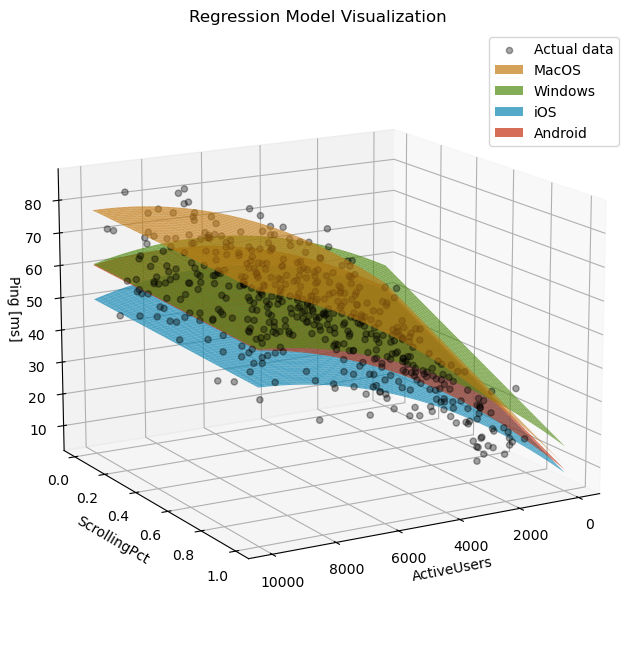

In [598]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')

# vykreslení naměřených hodnot
ax.scatter(initial_data['ActiveUsers'], initial_data['ScrollingPct'], y, color='black', alpha=0.35 , label='Actual data')

number_of_points = 100

x_axis_points = np.linspace(-1, 1, number_of_points)
y_axis_points = np.linspace(-1, 1, number_of_points)

x_surf, y_surf = np.meshgrid(x_axis_points, y_axis_points)

flattened_x = x_surf.flatten()
flattened_y = y_surf.flatten()

# denormalizace osy x a y
x_surf_denormalized = 10000 * (x_surf + 1) / 2
y_surf_denormalized = (y_surf + 1) / 2

os_cases = (
    ('MacOS', [1.0, -1.0, -1.0], "#C47B12"),
    ('Windows', [-1.0, 1.0, -1.0], "#508A11"),
    ('iOS', [-1.0, -1.0, 1.0] , "#0F86B3"),
    ('Android', [-1.0, -1.0, -1.0] , "#C53110")
)

base_predict_df = pd.DataFrame({
    'ActiveUsers': flattened_x, 
    'ActiveUsers_squared': flattened_x ** 2,
    'ScrollingPct': flattened_y,
    'ActiveUsers_ScrollingPct': flattened_y * flattened_x,
})

# vykreslení zakřivených ploch pro jednotlivé operační systémy
for os_name, os_values, os_color in os_cases:
  predict_df = sm.add_constant(base_predict_df.copy())

  predict_df[['IS_MacOS','IS_Windows','IS_iOS']] = os_values
  predict_df[['ActiveUsers_IS_MacOS', 'ActiveUsers_IS_Windows', 'ActiveUsers_IS_iOS']] = (
        predict_df['ActiveUsers'].values[:, np.newaxis] * np.array(os_values)
    )
  
  fittedY = model.predict(predict_df)

  fittedY = np.array(fittedY).reshape(x_surf_denormalized.shape)

  ax.plot_surface(x_surf_denormalized, y_surf_denormalized, fittedY, alpha=0.7, label=os_name, facecolor=os_color)

ax.set_xlabel('ActiveUsers')
ax.set_ylabel('ScrollingPct')
ax.set_zlabel('Ping [ms]', labelpad=0)
ax.view_init(elev=15, azim=60) 
plt.title('Regression Model Visualization')
plt.legend()
plt.show()


### Identifikace parametrů s nejproblematičtější hodnotou odezvy
Jestliže jakýmkoli způsobem zafixujeme parametry operačního systemů a procenta uživatelů, kteří pouze skrólují, dostaneme funkci pouze jedné proměnné, která je kvadratická a konkávní. To pro nás znamená, že dřív nebo později se pro dostatečně velké či malé číslo aktivních uživatelů dostaneme s predikovanou hodnotou do mínusu. Odezva je ale v našem případě definována jako kladné číslo, tedy predikce potom nedává žádný smysl.

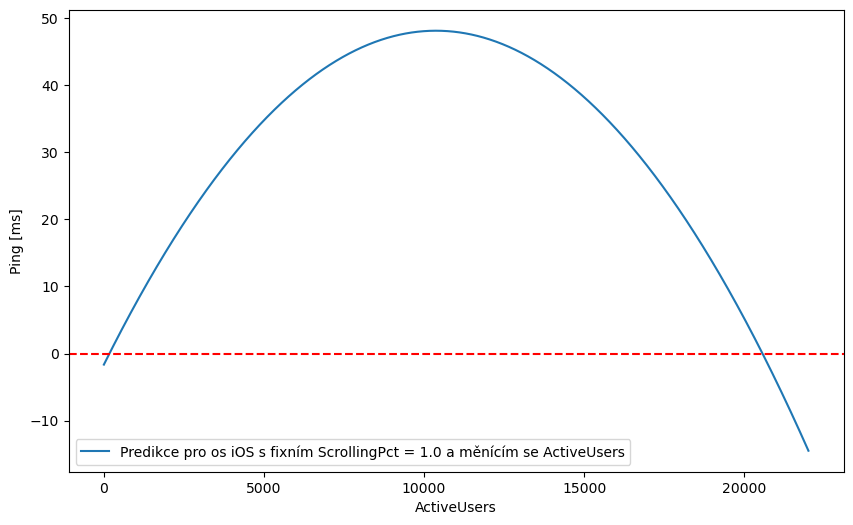

In [599]:
max_au, max_scroll = initial_data[['ActiveUsers', 'ScrollingPct']].max(axis=0)
min_au, min_scroll = initial_data[['ActiveUsers', 'ScrollingPct']].min(axis=0)

number_of_points = 2000
active_users_max_num = 22000

# vzorkování hodnot ActiveUsers od 1 až po 22000
x_axis_points = np.linspace(1, active_users_max_num, number_of_points)

# normalizace vstupních hodnot
active_users = -1 + 2 * (x_axis_points - min_au) / (max_au - min_au)
scrolling_pct = -1 + 2 * (np.array([1.0]*number_of_points) - min_scroll) / (max_scroll - min_scroll) 

# vytvoření data framu pro predikci
unseen_data = pd.DataFrame({
    'const': [1.0] * number_of_points, 
    'ActiveUsers': active_users,
    'ActiveUsers_squared' : active_users ** 2,
    'ScrollingPct': scrolling_pct,
    'ActiveUsers_ScrollingPct' : active_users * scrolling_pct,
    'IS_MacOS': [-1.0] * number_of_points,
    'IS_Windows': [-1.0] * number_of_points,
    'IS_iOS': [1.0] * number_of_points,
    'ActiveUsers_IS_MacOS': active_users * -1.0,
    'ActiveUsers_IS_Windows': active_users * -1.0,
    'ActiveUsers_IS_iOS': active_users * 1.0,
})

predictions = model.predict(unseen_data)

plt.figure(figsize=(10, 6))
plt.plot(x_axis_points, predictions, label='Predikce pro os iOS s fixním ScrollingPct = 1.0 a měnícím se ActiveUsers')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('ActiveUsers')
plt.ylabel('Ping [ms]')
plt.legend()
plt.show()

### Odezva pro uživatele s Windows

In [600]:
# vypočítáme průměrnou hodnotu ActiveUsers a ScrollingPct
mean_au, mean_scroll = initial_data[['ActiveUsers', 'ScrollingPct']].mean(axis=0)

# > 0.5 => IS_Windows == 1
windows_ping_mean = initial_data[initial_data["IS_Windows"] > 0.5][["Ping [ms]"]].mean().values[0]

# normalizujeme je
active_users = -1 + 2 * (mean_au - min_au) / (max_au - min_au)
scrolling_pct = -1 + 2 * (mean_scroll - min_scroll) / (max_scroll - min_scroll)

# vytvoříme data frame pro predikci
windows_average_load = pd.DataFrame({
    'const': [1.0], 
    'ActiveUsers': [active_users],
    'ActiveUsers_squared' : [active_users ** 2],
    'ScrollingPct': [scrolling_pct],
    'ActiveUsers_ScrollingPct' : [active_users * scrolling_pct],
    'IS_MacOS': [-1.0],
    'IS_Windows': [1.0],
    'IS_iOS': [-1.0],
    'ActiveUsers_IS_MacOS': [-active_users],
    'ActiveUsers_IS_Windows': [active_users],
    'ActiveUsers_IS_iOS': [-active_users],
})

windows_ping_prediction = model.predict(windows_average_load)[0]
summary_frame = model.get_prediction(windows_average_load).summary_frame(alpha=0.05) 

print("Predikce pro Windows:", round(windows_ping_prediction, 2))
print("Průměrný ping pro Windows:", round(windows_ping_mean, 2))

print(f'Konfidenční interval: <{round(summary_frame["mean_ci_lower"][0], 2)}, {round(summary_frame["mean_ci_upper"][0], 2)}>')
print(f'Predikční interval: <{round(summary_frame["obs_ci_lower"][0], 2)}, {round(summary_frame["obs_ci_upper"][0], 2)}>')


Predikce pro Windows: 55.0
Průměrný ping pro Windows: 51.43
Konfidenční interval: <53.97, 56.03>
Predikční interval: <44.72, 65.28>


### Znovupoužitelnost modelu
```
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Ping [ms]   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.28e-215
Time:                        20:50:26   Log-Likelihood:                -1528.7
No. Observations:                 500   AIC:                             3079.
Df Residuals:                     489   BIC:                             3126.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
Omnibus:                        0.661   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.750
Skew:                           0.014   Prob(JB):                        0.687
Kurtosis:                       2.812   Cond. No.                         6.96
==============================================================================

```
- Model má poměrně vysoký koeficient determinace - 0.877, což znamená, že 87.7% variability závislé proměnné je vysvětleno pomocí nezávislých proměnných. 

- Téměř stejnou hodnotu má i adjustovaný koeficient determinace - 0.875, který bere v úvahu i počet koeficientů v modelu, tedy penalizuje za velké množství koeficientů.

- Vysoká F-statistika 349.9 naznačuje, že model jako celek má statistický význam. Můžeme tedy s jistotou zamítnout nulovou hypotézu, že by všechny koeficienty současně měly být rovny nule. Jinými slovy, model má významný přínos k vysvětlení variability závislé proměnné.

- P-hodnoty Omnibus a JB testů jsou vysoké, což naznačuje, že rezidua modelu odpovídají normálnímu rozdělení, což je důležitý předpoklad pro OLS regresi.

- Hodnoty kurtosis a skewness naznačují, že rezidua nemají extrémní špičatost nebo asymetrii, což je v souladu s předpokladem normálního rozložení reziduí.

- U testu Durbin-Watson hodnota 1.990 naznačuje minimální nebo žádnou autokorelaci reziduí (ideální hodnota je 2). 

- Condition Number s hodnout 6.96 naznačuje, že v modelu nedochází k problémům s multikolinearitou (vzájemnou závislostí mezi nezávislými proměnnými).

Na základě výše vypsaných charakteristik bychom mohli říci, že by se model klidně pro predikování odezvy použít dal. Z předchozího bodu ale víme, že model "funguje" dobře, jestliže jeho vstup pro proměnnou `ActiveUsers`, omezíme intervalem $\langle min(ActiveUsers), max(ActiveUsers) \rangle$. Další alternativou by bylo odstranit kvadratický člen `ActiveUsers_squared`, což by mohlo zajistit konstatní růst odezvy se zvětšujícím se počtem uživatelů (nedostali bychom se do záporných čísel). 